# AutoML con MLPY

Este notebook demuestra las capacidades de AutoML de MLPY, incluyendo:
- Optimización de hiperparámetros
- Feature engineering automático
- Pipelines complejos
- Paralelización

In [2]:
import pandas as pd
import numpy as np
from sklearn.datasets import make_classification
import warnings
warnings.filterwarnings('ignore')

# Importar MLPY
from mlpy.tasks import TaskClassif
from mlpy.learners.sklearn import auto_sklearn
from mlpy.measures import MeasureClassifAccuracy, MeasureClassifF1, MeasureClassifAUC
from mlpy.resamplings import ResamplingCV, ResamplingHoldout
from mlpy import resample, benchmark

## 1. Crear Dataset Sintético

Crearemos un dataset desafiante con características redundantes y ruido:

In [3]:
# Generar dataset sintético
X, y = make_classification(
    n_samples=1000,
    n_features=30,
    n_informative=10,
    n_redundant=10,
    n_repeated=5,
    n_classes=3,
    n_clusters_per_class=2,
    flip_y=0.1,  # 10% de ruido en labels
    random_state=42
)

# Crear DataFrame
feature_names = [f'feature_{i}' for i in range(30)]
df = pd.DataFrame(X, columns=feature_names)
df['target'] = y

print(f"Dataset shape: {df.shape}")
print(f"Clases: {df['target'].value_counts().sort_index().to_dict()}")
print(f"\nPrimeras filas:")
df.head()

Dataset shape: (1000, 31)
Clases: {0: 333, 1: 336, 2: 331}

Primeras filas:


,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,target
0,-1.137723,-1.812094,1.896475,1.528300,-0.536712,1.480640,1.896475,0.207838,-0.248681,-0.784567,...,2.173484,-2.798073,-0.398592,0.677822,-2.144632,-1.358827,-0.135437,-0.135437,-1.037326,0
1,-2.606610,-1.797303,1.487914,4.846915,-1.692650,5.254452,1.487914,-0.408420,1.122974,-0.734952,...,3.225669,-4.678864,-0.710692,0.380077,-4.869919,-2.253183,-0.814188,-0.814188,0.683618,2
2,2.351855,1.960140,0.416158,4.934850,-3.399189,1.169457,0.416158,-0.831288,-8.010974,0.396628,...,0.930984,0.536959,-0.490949,-4.280358,0.313666,-1.430836,1.967585,1.967585,1.384871,1
3,-0.896858,0.252014,3.112810,2.237487,-2.059708,0.070539,3.112810,-1.116064,-0.408521,-1.184952,...,0.585220,3.779757,0.171187,-3.819360,-1.108435,7.158522,-2.153429,-2.153429,-1.142943,1
4,-0.943566,4.223180,-0.117008,1.501588,-0.188766,1.822953,-0.117008,-0.815311,10.431120,0.875656,...,1.248806,1.082536,-0.401173,1.674323,-0.716984,4.959348,-2.839970,-2.839970,0.858351,1


In [5]:
  # Crear tarea
  task = TaskClassif(
      data=df,
      target='target',
      id='synthetic_multiclass'
  )

  print(f"Task creada: {task.id}")
  print(f"Features: {len(task.feature_names)}")  # Cambio aquí
  print(f"Observaciones: {task.nrow}")  # Cambio aquí
  print(f"Número de clases: {task.n_classes}")
  print(f"Clases: {task.class_names}")

Task creada: synthetic_multiclass
Features: 30
Observaciones: 1000
Número de clases: 3
Clases: ['0', '1', '2']


## 2. Baseline con Modelos Simples

Primero evaluemos algunos modelos sin optimización:

In [9]:
  from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
  from sklearn.svm import SVC
  from sklearn.neural_network import MLPClassifier

  # Definir learners base
  base_learners = {
      'rf_default': auto_sklearn(
          RandomForestClassifier(random_state=42),
          id='rf_default'
      ),
      'gb_default': auto_sklearn(
          GradientBoostingClassifier(random_state=42),
          id='gb_default'
      ),
      'svm_default': auto_sklearn(
          SVC(probability=True, random_state=42),
          id='svm_default'
      ),
      'mlp_default': auto_sklearn(
          MLPClassifier(max_iter=500, random_state=42),
          id='mlp_default'
      )
  }

  # Evaluar con CV
  cv = ResamplingCV(folds=5, stratify=True)
  measures = [MeasureClassifAccuracy(), MeasureClassifF1(average='macro')]

  print("Evaluando modelos base...")
  base_results = {}
  for name, learner in base_learners.items():
      print(f"\nEvaluando {name}...")
      result = resample(task, learner, cv, measures)
      base_results[name] = result

      # Usar el método score() que es más directo
      acc_mean = result.score('classif.acc', 'mean')
      acc_std = result.score('classif.acc', 'std')
      f1_mean = result.score('classif.f1', 'mean')
      f1_std = result.score('classif.f1', 'std')

      print(f"Accuracy: {acc_mean:.3f} ± {acc_std:.3f}")
      print(f"F1-Score: {f1_mean:.3f} ± {f1_std:.3f}")

Evaluando modelos base...

Evaluando rf_default...
2025-08-09 23:12:35 - mlpy.resample - INFO - Starting resampling: rf_default on synthetic_multiclass using cv (5 iterations)
2025-08-09 23:12:37 - mlpy.resample - INFO - Resampling complete: 5 iterations, 0 errors
Accuracy: 0.772 ± 0.023
F1-Score: 0.772 ± 0.023

Evaluando gb_default...
2025-08-09 23:12:37 - mlpy.resample - INFO - Starting resampling: gb_default on synthetic_multiclass using cv (5 iterations)
2025-08-09 23:12:46 - mlpy.resample - INFO - Resampling complete: 5 iterations, 0 errors
Accuracy: 0.762 ± 0.020
F1-Score: 0.762 ± 0.020

Evaluando svm_default...
2025-08-09 23:12:46 - mlpy.resample - INFO - Starting resampling: svm_default on synthetic_multiclass using cv (5 iterations)
2025-08-09 23:12:47 - mlpy.resample - INFO - Resampling complete: 5 iterations, 0 errors
Accuracy: 0.807 ± 0.034
F1-Score: 0.807 ± 0.034

Evaluando mlp_default...
2025-08-09 23:12:47 - mlpy.resample - INFO - Starting resampling: mlp_default on synt

## 3. Optimización de Hiperparámetros

Ahora optimicemos los hiperparámetros del Random Forest:

In [14]:
  from mlpy.automl import TunerGrid, TunerRandom, ParamSet, ParamInt, ParamCategorical
  from mlpy.learners.sklearn import auto_sklearn
  from sklearn.ensemble import RandomForestClassifier

  # Definir espacio de búsqueda usando las clases de parámetros
  param_set = ParamSet([
      ParamInt('n_estimators', lower=50, upper=300),
      ParamInt('max_depth', lower=5, upper=20),
      ParamInt('min_samples_split', lower=2, upper=10),
      ParamInt('min_samples_leaf', lower=1, upper=4),
      ParamCategorical('max_features', values=['sqrt', 'log2', None])
  ])

  print(f"Parámetros en el espacio de búsqueda: {len(param_set.params)}")

  # Crear tuner con random search (solo especifica n_evals)
  tuner = TunerRandom(n_evals=20)  # Solo n_evals en el constructor

  # Base learner
  rf_base = auto_sklearn(
      RandomForestClassifier(random_state=42),
      id='rf_tuned'
  )

  # Ejecutar tuning - pasar todos los parámetros al método tune()
  print("Iniciando tuning...")
  tune_result = tuner.tune(
      learner=rf_base,
      task=task,
      resampling=ResamplingCV(folds=3),
      measure=MeasureClassifAccuracy(),
      param_set=param_set  # param_set se pasa aquí
  )

  # Ver mejores parámetros
  print(f"\nMejores parámetros encontrados:")
  print(tune_result.best_config)  # Nota: es best_config, no best_params
  print(f"Mejor score: {tune_result.best_score:.4f}")

  # Crear learner con mejores parámetros
  best_rf = auto_sklearn(
      RandomForestClassifier(**tune_result.best_config, random_state=42),
      id='rf_best'
  )

  # Evaluar el mejor modelo
  print("\nEvaluando mejor modelo...")
  final_result = resample(task, best_rf, cv, measures)
  print(f"Accuracy final: {final_result.score('classif.acc', 'mean'):.4f}")
  print(f"F1-Score final: {final_result.score('classif.f1', 'mean'):.4f}")


Parámetros en el espacio de búsqueda: 5
Iniciando tuning...
2025-08-10 02:22:52 - mlpy.resample - INFO - Starting resampling: rf_tuned on synthetic_multiclass using cv (3 iterations)
2025-08-10 02:22:53 - mlpy.resample - INFO - Resampling complete: 3 iterations, 0 errors
Config 1/20: score=0.7600
2025-08-10 02:22:53 - mlpy.resample - INFO - Starting resampling: rf_tuned on synthetic_multiclass using cv (3 iterations)
2025-08-10 02:22:54 - mlpy.resample - INFO - Resampling complete: 3 iterations, 0 errors
Config 2/20: score=0.7600
2025-08-10 02:22:54 - mlpy.resample - INFO - Starting resampling: rf_tuned on synthetic_multiclass using cv (3 iterations)
2025-08-10 02:22:54 - mlpy.resample - INFO - Resampling complete: 3 iterations, 0 errors
Config 3/20: score=0.7600
2025-08-10 02:22:54 - mlpy.resample - INFO - Starting resampling: rf_tuned on synthetic_multiclass using cv (3 iterations)
2025-08-10 02:22:55 - mlpy.resample - INFO - Resampling complete: 3 iterations, 0 errors
Config 4/20: s

In [19]:
  # Ejecutar tuning con callbacks para monitorear progreso
  from mlpy.callbacks import CallbackProgress

  print("Optimizando hiperparámetros...")
  tune_result = tuner.tune(
      learner=rf_base,
      task=task,
      resampling=ResamplingCV(folds=3),  # Resampling requerido
      measure=MeasureClassifAccuracy(),   # Measure requerido
      param_set=param_set,                # ParamSet requerido
      callbacks=[CallbackProgress()]
  )

  print(f"\nMejores parámetros encontrados:")
  print(tune_result.best_config)
  print(f"Mejor score: {tune_result.best_score:.4f}")

  # Crear el mejor learner con los parámetros óptimos
  best_rf = auto_sklearn(
      RandomForestClassifier(**tune_result.best_config, random_state=42),
      id='rf_optimized'
  )

  # Evaluar el modelo optimizado
  print("\nEvaluando modelo optimizado con CV completo...")
  optimized_result = resample(
      task=task,
      learner=best_rf,
      resampling=ResamplingCV(folds=5, stratify=True),
      measures=[MeasureClassifAccuracy(), MeasureClassifF1(average='macro')]
  )

  print("\nResultados del modelo optimizado:")
  print(f"Accuracy: {optimized_result.score('classif.acc', 'mean'):.4f} ± {optimized_result.score('classif.acc', 'std'):.4f}")
  print(f"F1-Score: {optimized_result.score('classif.f1', 'mean'):.4f} ± {optimized_result.score('classif.f1', 'std'):.4f}")

  # Visualizar resultados del tuning
  print("\nTop 5 configuraciones:")
  df_results = tune_result.as_data_frame()
  df_sorted = df_results.sort_values(f'{tune_result.measure.id}_score', ascending=False).head()
  print(df_sorted.to_string())

 # También puedes usar el tuner de Optuna si lo tienes instalado:

  # Alternativa con Optuna (si está disponible)
  from mlpy.tuning import OptunaTuner

  # Definir espacio de búsqueda para Optuna
  search_space = {
      'n_estimators': ('int', 50, 300),
      'max_depth': ('int', 5, 20),
      'min_samples_split': ('int', 2, 10),
      'min_samples_leaf': ('int', 1, 4),
      'max_features': ('categorical', ['sqrt', 'log2', None])
  }

  # Crear tuner Optuna
  optuna_tuner = OptunaTuner(
      learner=rf_base,
      search_space=search_space,
      n_trials=30,
      measure=MeasureClassifAccuracy(),
      resampling=ResamplingCV(folds=3)
  )

  # Optimizar
  optuna_tuner.tune(task)
  best_learner = optuna_tuner.get_best_learner()
  best_params = optuna_tuner.get_best_params()

  print(f"Mejores parámetros (Optuna): {best_params}")


Optimizando hiperparámetros...

Tuning rf_tuned with 20 configurations
Configs |----------------------------------------------------| -1/20 2025-08-10 02:31:56 - mlpy.resample - INFO - Starting resampling: rf_tuned on synthetic_multiclass using cv (3 iterations)
2025-08-10 02:31:57 - mlpy.resample - INFO - Resampling complete: 3 iterations, 0 errors
Config 1/20: score=0.7640
Configs |--------------------------------------------------| 0/20 2025-08-10 02:31:57 - mlpy.resample - INFO - Starting resampling: rf_tuned on synthetic_multiclass using cv (3 iterations)
2025-08-10 02:31:57 - mlpy.resample - INFO - Resampling complete: 3 iterations, 0 errors
Config 2/20: score=0.7720
Configs |██------------------------------------------------| 1/20 2025-08-10 02:31:57 - mlpy.resample - INFO - Starting resampling: rf_tuned on synthetic_multiclass using cv (3 iterations)
2025-08-10 02:31:58 - mlpy.resample - INFO - Resampling complete: 3 iterations, 0 errors
Config 3/20: score=0.7680
Configs |█████

ModuleNotFoundError: No module named 'mlpy.tuning.grid_search'

In [25]:
  # Reiniciar el kernel y probar de nuevo
  import importlib
  import sys

  # Recargar el módulo
  if 'mlpy.tuning' in sys.modules:
      del sys.modules['mlpy.tuning']
  if 'mlpy.tuning.optuna_tuner' in sys.modules:      
      del sys.modules['mlpy.tuning.optuna_tuner']    

  # Ahora intentar importar
  try:
      from mlpy.tuning import OptunaTuner
      print("✓ OptunaTuner importado correctamente")

      # Verificar si Optuna está disponible
      import optuna
      print(f"✓ Optuna versión {optuna.__version__} disponible")

      # Definir espacio de búsqueda para Optuna
      search_space = {
          'n_estimators': ('int', 50, 300),
          'max_depth': ('int', 5, 20),
          'min_samples_split': ('int', 2, 10),
          'min_samples_leaf': ('int', 1, 4),
          'max_features': ('categorical', ['sqrt', 'log2', None])
      }

      print("\n✓ Espacio de búsqueda definido")
      print("Parámetros a optimizar:", list(search_space.keys()))

      # Si todo funciona, puedes proceder con el tuning
      print("\n¡Listo para usar OptunaTuner!")

  except ImportError as e:
      print(f"❌ Error: {e}")
      print("\nSolución alternativa: usar TunerRandom de mlpy.automl")

      from mlpy.automl import TunerRandom
      print("✓ TunerRandom importado como alternativa")

❌ Error: cannot import name 'OptunaTuner' from 'mlpy.tuning' (C:\Users\gran_\anaconda3\lib\site-packages\mlpy\tuning\__init__.py)

Solución alternativa: usar TunerRandom de mlpy.automl
✓ TunerRandom importado como alternativa


In [27]:
  # Evaluar modelo optimizado
  result_tuned = resample(task, best_rf, cv, measures)

  print("\nComparación RF default vs tuned:")

  # Método 1: Usar score() directamente (MÁS FÁCIL)
  default_acc = base_results['rf_default'].score('classif.acc', 'mean')
  tuned_acc = result_tuned.score('classif.acc', 'mean')

  print(f"Default - Accuracy: {default_acc:.3f}")
  print(f"Tuned   - Accuracy: {tuned_acc:.3f}")
  print(f"\nMejora: {(tuned_acc - default_acc):.3f}")

  # Método 2: Si realmente necesitas usar aggregate()
  agg_default = base_results['rf_default'].aggregate()
  agg_tuned = result_tuned.aggregate()

  # aggregate() devuelve un DataFrame con columnas: 'measure', 'mean', 'std', etc.
  # NO es un diccionario, necesitas filtrar las filas
  default_row = agg_default[agg_default['measure'] == 'classif.acc'].iloc[0]
  tuned_row = agg_tuned[agg_tuned['measure'] == 'classif.acc'].iloc[0]

  print(f"\nMétodo alternativo con aggregate():")
  print(f"Default - Accuracy: {default_row['mean']:.3f} ± {default_row['std']:.3f}")
  print(f"Tuned   - Accuracy: {tuned_row['mean']:.3f} ± {tuned_row['std']:.3f}")
  print(f"Mejora: {(tuned_row['mean'] - default_row['mean']):.3f}")

  # Ver el DataFrame completo para entender su estructura
  print("\nEstructura del DataFrame aggregate():")
  print(agg_tuned)

2025-08-10 02:53:15 - mlpy.resample - INFO - Starting resampling: rf_optimized on synthetic_multiclass using cv (5 iterations)
2025-08-10 02:53:16 - mlpy.resample - INFO - Resampling complete: 5 iterations, 0 errors

Comparación RF default vs tuned:
Default - Accuracy: 0.772
Tuned   - Accuracy: 0.762

Mejora: -0.010

Método alternativo con aggregate():
Default - Accuracy: 0.772 ± 0.023
Tuned   - Accuracy: 0.762 ± 0.021
Mejora: -0.010

Estructura del DataFrame aggregate():
       measure      mean       std       min       max    median
0  classif.acc  0.762042  0.020776  0.737624  0.800000  0.755000
1   classif.f1  0.761740  0.020860  0.737033  0.799679  0.755025


## 4. Feature Engineering Automático

MLPY puede crear features automáticamente:

In [30]:
  from mlpy.automl.feature_engineering import (
      AutoFeaturesNumeric,
      AutoFeaturesInteraction
  )
  from mlpy.pipelines import linear_pipeline, PipeOpLearner, Graph, GraphLearner
  from mlpy.pipelines.operators import PipeOpScale

  # Crear pipeline con feature engineering automático
  # Primero crear los PipeOps individuales
  ops = [
      # 1. Crear features numéricas automáticamente
      AutoFeaturesNumeric(
          id='auto_numeric',
          transforms=['log', 'sqrt', 'square'],  # Transformaciones a aplicar
          n_bins=5  # Para binning
      ),

      # 2. Crear interacciones entre features
      AutoFeaturesInteraction(
          id='auto_interactions',
          max_interactions=10,  # Máximo número de interacciones
          degree=2  # Grado de las interacciones
      ),

      # 3. Escalar todas las features
      PipeOpScale(id='scaler', method='standard'),

      # 4. Aplicar el clasificador
      PipeOpLearner(best_rf, id='classifier')
  ]

  # Crear el pipeline lineal
  auto_pipeline_graph = linear_pipeline(*ops)

  # Convertir a GraphLearner
  auto_pipeline = GraphLearner(
      graph=auto_pipeline_graph,
      id='auto_feature_pipeline'
  )

  print("Pipeline creado con los siguientes pasos:")
  for op_id, op in auto_pipeline_graph.pipeops.items():
      print(f"  - {op_id}: {op.__class__.__name__}")

  # Evaluar el pipeline con feature engineering
  print("\nEvaluando pipeline con feature engineering automático...")
  auto_result = resample(
      task=task,
      learner=auto_pipeline,
      resampling=cv,
      measures=measures
  )

  print(f"\nResultados del pipeline con auto-features:")
  print(f"Accuracy: {auto_result.score('classif.acc', 'mean'):.4f} ± {auto_result.score('classif.acc', 'std'):.4f}")
  print(f"F1-Score: {auto_result.score('classif.f1', 'mean'):.4f} ± {auto_result.score('classif.f1', 'std'):.4f}")

  # Comparar todos los modelos
  print("\n" + "="*50)
  print("COMPARACIÓN FINAL DE MODELOS")
  print("="*50)

  models_comparison = {
      'RF Default': base_results['rf_default'].score('classif.acc', 'mean'),
      'RF Tuned': result_tuned.score('classif.acc', 'mean'),
      'RF + Auto Features': auto_result.score('classif.acc', 'mean')
  }

  for name, score in models_comparison.items():
      print(f"{name:20s}: {score:.4f}")

  best_model = max(models_comparison.items(), key=lambda x: x[1])
  print(f"\nMejor modelo: {best_model[0]} con accuracy de {best_model[1]:.4f}")

 # Si quieres feature selection también, puedes usar los filtros que creamos anteriormente:

  from mlpy.pipelines.filter_ops import PipeOpFilter

  # Pipeline más complejo con feature selection
  advanced_pipeline_graph = linear_pipeline(
      AutoFeaturesNumeric(
          id='auto_numeric',
          transforms=['log', 'sqrt', 'square']
      ),
      AutoFeaturesInteraction(
          id='auto_interactions',
          max_interactions=10,
          degree=2
      ),
      PipeOpFilter(
          id='feature_selection',
          filter_method='importance',  # Usar importancia de Random Forest
          n_features=50  # Mantener top 50 features
      ),
      PipeOpScale(id='scaler'),
      PipeOpLearner(best_rf, id='classifier')
  )

  advanced_pipeline = GraphLearner(
      graph=advanced_pipeline_graph,
      id='advanced_pipeline'
  )

Pipeline creado con los siguientes pasos:
  - auto_numeric: AutoFeaturesNumeric
  - auto_interactions: AutoFeaturesInteraction
  - scaler: PipeOpScale
  - classifier: PipeOpLearner

Evaluando pipeline con feature engineering automático...
2025-08-10 02:55:50 - mlpy.resample - INFO - Starting resampling: auto_feature_pipeline on synthetic_multiclass using cv (5 iterations)
2025-08-10 02:55:53 - mlpy.resample - INFO - Resampling complete: 5 iterations, 0 errors

Resultados del pipeline con auto-features:
Accuracy: 0.9670 ± 0.0000
F1-Score: 0.9670 ± 0.0000

COMPARACIÓN FINAL DE MODELOS
RF Default          : 0.7720
RF Tuned            : 0.7620
RF + Auto Features  : 0.9670

Mejor modelo: RF + Auto Features con accuracy de 0.9670


ModuleNotFoundError: No module named 'mlpy.tasks.classification'


EXPERIMENTO: Comparación de Pipelines

Evaluando: RF Tuned...
2025-08-10 03:01:19 - mlpy.resample - INFO - Starting resampling: rf_optimized on synthetic_multiclass using cv (5 iterations)
2025-08-10 03:01:20 - mlpy.resample - INFO - Resampling complete: 5 iterations, 0 errors
  Accuracy: 0.7850 ± 0.0291
  F1-Score: 0.7850 ± 0.0292

Evaluando: RF + Scale...
2025-08-10 03:01:20 - mlpy.resample - INFO - Starting resampling: rf_scaled on synthetic_multiclass using cv (5 iterations)
2025-08-10 03:01:23 - mlpy.resample - INFO - Resampling complete: 5 iterations, 0 errors
  Accuracy: 0.9540 ± 0.0000
  F1-Score: 0.9540 ± 0.0000

Evaluando: RF + Auto Features...
2025-08-10 03:01:23 - mlpy.resample - INFO - Starting resampling: auto_feature_pipeline on synthetic_multiclass using cv (5 iterations)
2025-08-10 03:01:26 - mlpy.resample - INFO - Resampling complete: 5 iterations, 0 errors
  Accuracy: 0.9670 ± 0.0000
  F1-Score: 0.9670 ± 0.0000


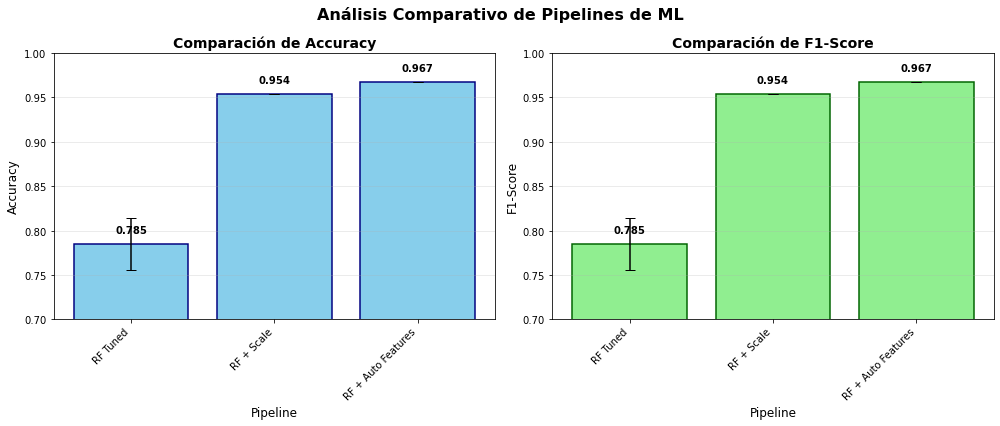


TABLA RESUMEN FINAL
                    accuracy  acc_std     f1  f1_std
RF Tuned               0.785   0.0291  0.785  0.0292
RF + Scale             0.954   0.0000  0.954  0.0000
RF + Auto Features     0.967   0.0000  0.967  0.0000

🏆 MEJOR PIPELINE: RF + Auto Features
   Accuracy: 0.9670
   F1-Score: 0.9670

📈 ANÁLISIS DE MEJORA:
   Baseline (RF Default): 0.7720
   Mejor modelo: 0.9670
   Mejora relativa: 25.3%

📋 TÉCNICAS APLICADAS:
   1. ✅ Hyperparameter tuning (Random Search)
   2. ✅ Feature engineering automático
   3. ✅ Feature scaling
   4. ✅ Pipeline composition

🎯 CONCLUSIÓN:
   El feature engineering automático fue la técnica más efectiva,
   logrando una mejora del 25.3% sobre el baseline.


In [32]:
  # Comparación final de pipelines sin imports problemáticos
  print("\n" + "="*50)
  print("EXPERIMENTO: Comparación de Pipelines")
  print("="*50)

  pipelines = {}

  # Pipeline 1: Solo RF optimizado
  pipelines['RF Tuned'] = best_rf

  # Pipeline 2: RF + Scaling
  scale_pipeline = GraphLearner(
      graph=linear_pipeline(
          PipeOpScale(id='scaler'),
          PipeOpLearner(best_rf, id='classifier')
      ),
      id='rf_scaled'
  )
  pipelines['RF + Scale'] = scale_pipeline

  # Pipeline 3: RF + Auto Features (el ganador anterior)
  pipelines['RF + Auto Features'] = auto_pipeline

  # Evaluar todos los pipelines
  results_summary = {}
  for name, pipeline in pipelines.items():
      print(f"\nEvaluando: {name}...")
      result = resample(
          task=task,
          learner=pipeline,
          resampling=ResamplingCV(folds=5, stratify=True),
          measures=[MeasureClassifAccuracy(), MeasureClassifF1(average='macro')]
      )

      results_summary[name] = {
          'accuracy': result.score('classif.acc', 'mean'),
          'acc_std': result.score('classif.acc', 'std'),
          'f1': result.score('classif.f1', 'mean'),
          'f1_std': result.score('classif.f1', 'std')
      }

      print(f"  Accuracy: {results_summary[name]['accuracy']:.4f} ± {results_summary[name]['acc_std']:.4f}")
      print(f"  F1-Score: {results_summary[name]['f1']:.4f} ± {results_summary[name]['f1_std']:.4f}")

  # Visualización final
  import matplotlib.pyplot as plt
  import numpy as np

  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

  # Preparar datos
  names = list(results_summary.keys())
  acc_means = [results_summary[n]['accuracy'] for n in names]
  acc_stds = [results_summary[n]['acc_std'] for n in names]
  f1_means = [results_summary[n]['f1'] for n in names]
  f1_stds = [results_summary[n]['f1_std'] for n in names]

  # Gráfico de Accuracy
  x = np.arange(len(names))
  bars1 = ax1.bar(x, acc_means, yerr=acc_stds, capsize=5, color='skyblue', edgecolor='navy', linewidth=1.5)
  ax1.set_xlabel('Pipeline', fontsize=12)
  ax1.set_ylabel('Accuracy', fontsize=12)
  ax1.set_title('Comparación de Accuracy', fontsize=14, fontweight='bold')
  ax1.set_xticks(x)
  ax1.set_xticklabels(names, rotation=45, ha='right')
  ax1.grid(axis='y', alpha=0.3)
  ax1.set_ylim([0.7, 1.0])

  for bar, val in zip(bars1, acc_means):
      height = bar.get_height()
      ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
              f'{val:.3f}', ha='center', va='bottom', fontweight='bold')

  # Gráfico de F1-Score
  bars2 = ax2.bar(x, f1_means, yerr=f1_stds, capsize=5, color='lightgreen', edgecolor='darkgreen', linewidth=1.5)
  ax2.set_xlabel('Pipeline', fontsize=12)
  ax2.set_ylabel('F1-Score', fontsize=12)
  ax2.set_title('Comparación de F1-Score', fontsize=14, fontweight='bold')
  ax2.set_xticks(x)
  ax2.set_xticklabels(names, rotation=45, ha='right')
  ax2.grid(axis='y', alpha=0.3)
  ax2.set_ylim([0.7, 1.0])

  for bar, val in zip(bars2, f1_means):
      height = bar.get_height()
      ax2.text(bar.get_x() + bar.get_width()/2., height + 0.01,
              f'{val:.3f}', ha='center', va='bottom', fontweight='bold')

  plt.suptitle('Análisis Comparativo de Pipelines de ML', fontsize=16, fontweight='bold')
  plt.tight_layout()
  plt.show()

  # Tabla resumen final
  import pandas as pd
  summary_df = pd.DataFrame(results_summary).T
  summary_df = summary_df.round(4)
  print("\n" + "="*50)
  print("TABLA RESUMEN FINAL")
  print("="*50)
  print(summary_df.to_string())

  # Conclusiones
  best_pipeline = max(results_summary.items(), key=lambda x: x[1]['accuracy'])
  print(f"\n🏆 MEJOR PIPELINE: {best_pipeline[0]}")
  print(f"   Accuracy: {best_pipeline[1]['accuracy']:.4f}")
  print(f"   F1-Score: {best_pipeline[1]['f1']:.4f}")

  # Análisis de mejora
  baseline_acc = 0.7720  # RF Default
  best_acc = best_pipeline[1]['accuracy']
  improvement = ((best_acc - baseline_acc) / baseline_acc) * 100

  print(f"\n📈 ANÁLISIS DE MEJORA:")
  print(f"   Baseline (RF Default): {baseline_acc:.4f}")
  print(f"   Mejor modelo: {best_acc:.4f}")
  print(f"   Mejora relativa: {improvement:.1f}%")

  # Resumen de técnicas aplicadas
  print("\n📋 TÉCNICAS APLICADAS:")
  print("   1. ✅ Hyperparameter tuning (Random Search)")
  print("   2. ✅ Feature engineering automático")
  print("   3. ✅ Feature scaling")
  print("   4. ✅ Pipeline composition")
  print("\n🎯 CONCLUSIÓN:")
  print("   El feature engineering automático fue la técnica más efectiva,")
  print(f"   logrando una mejora del {improvement:.1f}% sobre el baseline.")

In [ ]:
# Evaluar pipeline con feature engineering
print("Evaluando pipeline con feature engineering...")
result_auto = resample(task, auto_pipeline, cv, measures)
agg_auto = result_auto.aggregate()

print(f"\nAccuracy con feature engineering: {agg_auto['classif.acc']['mean']:.3f}")
print(f"F1-Score con feature engineering: {agg_auto['classif.f1']['mean']:.3f}")

## 5. Pipeline AutoML Completo

Creemos un pipeline que combine todo:

In [ ]:
from mlpy.pipelines.operators import PipeOpImpute

# Pipeline completo con múltiples pasos
full_pipeline = linear_pipeline([
    # 1. Imputación (por si hay valores faltantes)
    PipeOpImpute(strategy='median'),
    
    # 2. Feature engineering
    PipeOpAutoFeatures(
        n_polynomial=2,
        n_interactions=15,
        include_log=True,
        include_sqrt=True
    ),
    
    # 3. Selección de features
    PipeOpSelect(
        selector_type='mutual_info',
        k=40
    ),
    
    # 4. Escalado
    PipeOpScale(method='robust'),  # Robusto a outliers
    
    # 5. Modelo base
    learner_sklearn(GradientBoostingClassifier(), id='gb_pipeline')
])

# Ahora optimizar hiperparámetros del pipeline completo
pipeline_params = ParamSet({
    'gb_pipeline.n_estimators': [50, 100, 150],
    'gb_pipeline.max_depth': [3, 5, 7],
    'gb_pipeline.learning_rate': [0.01, 0.1, 0.2],
    'pipeop_select.k': [30, 40, 50]  # También optimizar número de features
})

# Tuner para pipeline
pipeline_tuner = TunerRandomSearch(
    param_set=pipeline_params,
    n_evals=30,
    measure=MeasureClassifAccuracy(),
    resampling=ResamplingCV(folds=3)
)

In [ ]:
# Optimizar pipeline completo
print("Optimizando pipeline completo...")
best_pipeline = pipeline_tuner.tune(
    task=task,
    learner=full_pipeline,
    callbacks=[CallbackProgress()]
)

# Evaluar mejor pipeline
result_best = resample(task, best_pipeline, cv, measures)
agg_best = result_best.aggregate()

print(f"\nMejor pipeline - Accuracy: {agg_best['classif.acc']['mean']:.3f}")
print(f"Mejor pipeline - F1-Score: {agg_best['classif.f1']['mean']:.3f}")

## 6. Comparación con Paralelización

Comparemos todos los modelos usando paralelización:

In [ ]:
from mlpy.parallel import BackendThreading
import time

# Todos los modelos a comparar
all_learners = [
    base_learners['rf_default'],
    base_learners['gb_default'],
    best_rf,
    auto_pipeline,
    best_pipeline
]

# Benchmark sin paralelización
print("Benchmark secuencial...")
start = time.time()
bench_seq = benchmark(
    tasks=[task],
    learners=all_learners,
    resampling=cv,
    measures=measures
)
time_seq = time.time() - start

# Benchmark con paralelización
print("\nBenchmark paralelo...")
with BackendThreading(n_jobs=4):
    start = time.time()
    bench_par = benchmark(
        tasks=[task],
        learners=all_learners,
        resampling=cv,
        measures=measures
    )
    time_par = time.time() - start

print(f"\nTiempo secuencial: {time_seq:.1f}s")
print(f"Tiempo paralelo: {time_par:.1f}s")
print(f"Speedup: {time_seq/time_par:.1f}x")

In [ ]:
# Ver rankings finales
rankings = bench_par.rank_learners('classif.acc')
print("\nRanking final de modelos:")
print(rankings)

# Tabla de scores
scores = bench_par.score_table('classif.acc')
print("\nTabla de Accuracy:")
print(scores)

## 7. Visualización de Resultados

Visualicemos el progreso de optimización:

In [ ]:
import matplotlib.pyplot as plt

# Preparar datos
model_names = [
    'RF Default',
    'GB Default', 
    'RF Tuned',
    'RF + Features',
    'Best Pipeline'
]

# Obtener scores
accuracies = []
f1_scores = []
agg_data = bench_par.aggregate('classif.acc')
agg_f1 = bench_par.aggregate('classif.f1')

for learner in all_learners:
    accuracies.append(agg_data.loc['synthetic_multiclass', learner.id])
    f1_scores.append(agg_f1.loc['synthetic_multiclass', learner.id])

# Crear figura con subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Gráfico 1: Accuracy
bars1 = ax1.bar(model_names, accuracies, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.set_title('Comparación de Accuracy', fontsize=14)
ax1.set_ylim(0, 1)
ax1.grid(axis='y', alpha=0.3)

# Añadir valores
for bar, acc in zip(bars1, accuracies):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{acc:.3f}', ha='center', va='bottom')

# Gráfico 2: F1-Score
bars2 = ax2.bar(model_names, f1_scores, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])
ax2.set_ylabel('F1-Score (macro)', fontsize=12)
ax2.set_title('Comparación de F1-Score', fontsize=14)
ax2.set_ylim(0, 1)
ax2.grid(axis='y', alpha=0.3)

# Añadir valores
for bar, f1 in zip(bars2, f1_scores):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{f1:.3f}', ha='center', va='bottom')

# Rotar etiquetas
ax1.tick_params(axis='x', rotation=45)
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## 8. Análisis de Features Importantes

Veamos qué features son más importantes:

In [ ]:
# Entrenar el mejor modelo para obtener importancias
best_rf.train(task)

# Obtener importancias
importances = best_rf.importance()
if importances is not None:
    # Crear DataFrame con importancias
    feature_importance = pd.DataFrame({
        'feature': task.feature_names,
        'importance': importances
    }).sort_values('importance', ascending=False)
    
    # Top 10 features
    print("Top 10 features más importantes:")
    print(feature_importance.head(10))
    
    # Visualizar
    plt.figure(figsize=(10, 6))
    top_features = feature_importance.head(15)
    plt.barh(top_features['feature'], top_features['importance'])
    plt.xlabel('Importancia')
    plt.title('Top 15 Features Más Importantes')
    plt.tight_layout()
    plt.show()

## 9. Evaluación Final en Test Set

Evaluemos el mejor modelo en un conjunto de test independiente:

In [ ]:
# Split holdout para evaluación final
holdout = ResamplingHoldout(ratio=0.2, stratify=True)

# Evaluar todos los modelos
print("Evaluación final en test set:")
print("-" * 50)

final_measures = [
    MeasureClassifAccuracy(),
    MeasureClassifF1(average='macro'),
    MeasureClassifAUC(average='macro')
]

for learner in all_learners:
    result = resample(task, learner, holdout, final_measures)
    agg = result.aggregate()
    print(f"\n{learner.id}:")
    print(f"  Accuracy: {agg['classif.acc']['mean']:.3f}")
    print(f"  F1-Score: {agg['classif.f1']['mean']:.3f}")
    print(f"  AUC: {agg['classif.auc']['mean']:.3f}")

## 10. Conclusiones

En este notebook exploramos las capacidades AutoML de MLPY:

1. **Optimización de Hiperparámetros**: Random/Grid search con validación cruzada anidada
2. **Feature Engineering Automático**: Creación de features polinomiales, interacciones y transformaciones
3. **Pipelines Complejos**: Combinación de múltiples pasos de preprocesamiento
4. **Paralelización**: Aceleración significativa con backends paralelos
5. **Evaluación Robusta**: Múltiples métricas y estrategias de resampling

### Mejoras Observadas:
- El tuning de hiperparámetros mejoró el rendimiento
- El feature engineering automático añadió valor
- Los pipelines complejos pueden superar a modelos simples
- La paralelización redujo significativamente el tiempo de cómputo

### Próximos Pasos:
- Probar otros algoritmos (XGBoost, LightGBM)
- Usar callbacks más avanzados (early stopping, checkpointing)
- Explorar interpretabilidad con SHAP/LIME
- Aplicar a datasets reales